In [17]:
# === Core Imports ===
import os
import re
import requests
import datetime
import asyncio
import tempfile
from typing import Optional, List, Literal, Dict, Any
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from dotenv import load_dotenv

# === LangChain Core ===
from langchain_groq import ChatGroq
from langchain_google_genai import ChatGoogleGenerativeAI  # Added for Gemini
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.memory import ConversationBufferMemory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain.memory.chat_message_histories import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.messages import trim_messages
from langgraph.graph import StateGraph, START, END

# === Document Processing ===
import fitz  # PyMuPDF
import pytesseract
from PIL import Image
import cv2
import numpy as np
import arxiv

# === Token Management ===
import tiktoken

# === Web Framework ===
from fastapi import FastAPI, UploadFile, File, Form
from fastapi.staticfiles import StaticFiles
from fastapi.responses import HTMLResponse
import uvicorn

print("✅ All imports successful (with Gemini support)")


✅ All imports successful (with Gemini support)


In [18]:
# === Environment Setup ===
load_dotenv()

# === API Keys Configuration ===
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")  # For Gemini models
GROQ_API_KEY = os.getenv("GROQ_API_KEY") 
BRAVE_API_KEY = os.getenv("BRAVE_API_KEY")  # For internet search

# === Model Configuration ===
PRIMARY_GEMINI_MODEL = "gemini-1.5-flash"      # For complex analysis and research
FAST_GEMINI_MODEL = "gemini-1.5-flash"      # For quick routing and formatting
FALLBACK_MODEL = "gemma2-9b-it"             # Groq fallback if Gemini fails

# === LLM Initialization ===
try:
    # Primary Gemini model for complex research tasks
    if GOOGLE_API_KEY:
        primary_llm = ChatGoogleGenerativeAI(
            model=PRIMARY_GEMINI_MODEL,
            temperature=0.3,
            google_api_key=GOOGLE_API_KEY,
            convert_system_message_to_human=True  # Important for Gemini compatibility
        )
        print(f"✅ Gemini primary model initialized: {PRIMARY_GEMINI_MODEL}")
        
        # Fast Gemini model for routing and simple tasks
        fast_llm = ChatGoogleGenerativeAI(
            model=FAST_GEMINI_MODEL,
            temperature=0.2,
            google_api_key=GOOGLE_API_KEY,
            convert_system_message_to_human=True
        )
        print(f"✅ Gemini fast model initialized: {FAST_GEMINI_MODEL}")
        
    else:
        # Fallback to Groq if no Google API key
        print("⚠️ No Google API key found, falling back to Groq models")
        primary_llm = ChatGroq(model=FALLBACK_MODEL, groq_api_key=GROQ_API_KEY, temperature=0.3)
        fast_llm = ChatGroq(model=FALLBACK_MODEL, groq_api_key=GROQ_API_KEY, temperature=0.2)
        print("✅ Groq fallback models initialized")
    
except Exception as e:
    print(f"❌ Primary model initialization failed: {e}")
    print("🔄 Attempting Groq fallback...")
    try:
        primary_llm = ChatGroq(model=FALLBACK_MODEL, groq_api_key=GROQ_API_KEY, temperature=0.3)
        fast_llm = ChatGroq(model=FALLBACK_MODEL, groq_api_key=GROQ_API_KEY, temperature=0.2)
        print("✅ Groq fallback models initialized successfully")
    except Exception as fallback_error:
        print(f"❌ All model initialization failed: {fallback_error}")
        raise

# === Enhanced Model Configuration for Research Tasks ===
# Configure specific models for different research tasks
RESEARCH_MODELS = {
    "complex_analysis": primary_llm,    # For research summaries and complex analysis
    "fast_routing": fast_llm,           # For query formatting and routing
    "qa_specialist": fast_llm,       # For detailed Q&A responses
    "document_analysis": primary_llm    # For document processing and analysis
}

# === Token Management ===
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
def count_tokens(message: BaseMessage) -> int:
    text = getattr(message, "content", str(message))
    return len(encoding.encode(text))

# === Session Management ===
session_store = {}
def get_chat_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in session_store:
        session_store[session_id] = ChatMessageHistory()
    return session_store[session_id]

# === Gemini-Specific Configuration ===
GEMINI_CONFIG = {
    "safety_settings": {
        "HARM_CATEGORY_HARASSMENT": "BLOCK_NONE",
        "HARM_CATEGORY_HATE_SPEECH": "BLOCK_NONE", 
        "HARM_CATEGORY_SEXUALLY_EXPLICIT": "BLOCK_NONE",
        "HARM_CATEGORY_DANGEROUS_CONTENT": "BLOCK_NONE"
    },
    "generation_config": {
        "temperature": 0.3,
        "top_p": 0.8,
        "top_k": 40,
        "max_output_tokens": 8192
    }
}

print("✅ Configuration completed with Gemini models")
print(f"📊 Models configured:")
print(f"   • Primary: {PRIMARY_GEMINI_MODEL if GOOGLE_API_KEY else FALLBACK_MODEL}")
print(f"   • Fast: {FAST_GEMINI_MODEL if GOOGLE_API_KEY else FALLBACK_MODEL}")
print(f"   • Provider: {'Google Gemini' if GOOGLE_API_KEY else 'Groq'}")


⚠️ No Google API key found, falling back to Groq models
✅ Groq fallback models initialized
✅ Configuration completed with Gemini models
📊 Models configured:
   • Primary: gemma2-9b-it
   • Fast: gemma2-9b-it
   • Provider: Groq


In [19]:
# === Graph State Definition ===
class ResearchState(TypedDict):
    # User input
    original_question: str
    formatted_question: str
    session_id: str
    
    # Document sources
    uploaded_documents: List[str]  # Processed content from PDFs/docs
    internet_results: List[str]    # Web search results
    arxiv_results: List[str]       # ArXiv paper results
    
    # Processing results
    research_summary: str          # Comprehensive summary from all sources
    current_context: str           # Current conversation context
    
    # Q&A system
    user_question: str            # Follow-up questions
    specialist_response: str       # Detailed answers from specialist
    
    # Metadata
    processing_stage: str
    errors: List[str]
    token_count: int

def create_initial_state(original_question: str, session_id: str, uploaded_docs: List[str] = None) -> ResearchState:
    """Create initial research state"""
    return ResearchState(
        original_question=original_question,
        formatted_question="",
        session_id=session_id,
        uploaded_documents=uploaded_docs or [],
        internet_results=[],
        arxiv_results=[],
        research_summary="",
        current_context="",
        user_question="",
        specialist_response="",
        processing_stage="initialized",
        errors=[],
        token_count=0
    )

def update_research_state(state: ResearchState, **updates) -> ResearchState:
    """Update research state with new values"""
    updated_state = state.copy()
    for key, value in updates.items():
        if key in updated_state:
            updated_state[key] = value
    updated_state["token_count"] = sum(count_tokens(HumanMessage(content=str(v))) for v in updated_state.values() if isinstance(v, str))
    return updated_state

print("✅ State definition completed")


✅ State definition completed


In [20]:
async def formatter_node(state: ResearchState) -> ResearchState:
    """
    Formats user queries to be more specific and searchable for research agents
    """
    print("🔧 Starting query formatting...")
    
    try:
        original_question = state["original_question"]
        
        formatter_prompt = ChatPromptTemplate.from_messages([
            ("system", """
You are a Query Enhancement Specialist for academic and research purposes. 

Your role is to transform user queries into well-structured, research-focused questions that will help downstream agents find the most relevant and comprehensive information.

ENHANCEMENT RULES:
1. Make vague queries specific and searchable
2. Add context for technical terms when needed
3. Break complex queries into focused research directions
4. Preserve the original intent while improving clarity
5. Add relevant keywords that would help in academic searches
6. Ensure the query is suitable for both internet search and academic paper search

EXAMPLES:
- "AI in healthcare" → "Applications of artificial intelligence and machine learning in healthcare diagnosis, treatment, and patient care"
- "quantum computing" → "Current state of quantum computing technology, applications, and recent research breakthroughs"
- "climate change effects" → "Environmental and socioeconomic impacts of climate change, recent scientific findings and mitigation strategies"

RESPONSE FORMAT:
Provide only the enhanced query without explanations or additional text.
"""),
            ("human", "Original query: {question}")
        ])
        
        formatter_chain = formatter_prompt | fast_llm
        
        # Get chat history for context
        chat_hist = get_chat_history(state["session_id"])
        
        # Format the query
        response = await formatter_chain.ainvoke({"question": original_question})
        formatted_question = response.content.strip()
        
        # Add to chat history
        chat_hist.add_user_message(f"Research query: {original_question}")
        
        print(f"✅ Query formatted: {original_question[:50]}... → {formatted_question[:50]}...")
        
        return update_research_state(
            state,
            formatted_question=formatted_question,
            processing_stage="query_formatted"
        )
        
    except Exception as e:
        error_msg = f"Query formatting failed: {str(e)}"
        print(f"❌ {error_msg}")
        
        return update_research_state(
            state,
            formatted_question=state["original_question"],  # Fallback to original
            processing_stage="formatting_failed",
            errors=state["errors"] + [error_msg]
        )


In [21]:

# === Internet Search Node ===
async def internet_search_node(state: ResearchState) -> ResearchState:
    """
    Searches the internet for current information on the research topic
    """
    print("🌐 Starting internet search...")
    
    try:
        search_query = state["formatted_question"]
        
        # Primary search using Brave Search API
        if BRAVE_API_KEY:
            try:
                print("🔍 Using Brave Search API...")
                url = "https://api.search.brave.com/res/v1/web/search"
                headers = {
                    "Accept": "application/json",
                    "X-Subscription-Token": BRAVE_API_KEY,
                }
                params = {
                    "q": search_query,
                    "count": 10,  # Get more results for research
                    "search_lang": "en",
                    "country": "us",
                    "safesearch": "strict"
                }
                
                response = requests.get(url, headers=headers, params=params, timeout=10)
                response.raise_for_status()
                
                search_data = response.json()
                results = search_data.get("web", {}).get("results", [])
                
                formatted_results = []
                for i, result in enumerate(results[:8], 1):  # Top 8 results
                    formatted_result = f"""
**Result {i}: {result.get('title', 'No Title')}**
URL: {result.get('url', 'No URL')}
Description: {result.get('description', 'No description available')}
Published: {result.get('published', 'No date')}

---"""
                    formatted_results.append(formatted_result)
                
                internet_content = "\n".join(formatted_results)
                print(f"✅ Brave Search: Found {len(results)} results")
                
            except Exception as e:
                print(f"⚠️ Brave Search failed: {e}, trying fallback...")
                internet_content = f"Internet search temporarily unavailable. Error: {str(e)}"
        
        else:
            # Fallback: Basic web search simulation
            print("⚠️ No Brave API key, using fallback search simulation...")
            internet_content = f"""
**Simulated Internet Search Results for: {search_query}**

Note: This is a placeholder. To enable real internet search, please configure BRAVE_API_KEY in your environment.

For your research query "{search_query}", you would typically find:
- Recent news articles and updates
- Current industry reports and analyses  
- Latest developments and trends
- Expert opinions and commentary
- Statistical data and market research

Please configure internet search API for actual results.
"""
        
        return update_research_state(
            state,
            internet_results=[internet_content],
            processing_stage="internet_search_completed"
        )
        
    except Exception as e:
        error_msg = f"Internet search failed: {str(e)}"
        print(f"❌ {error_msg}")
        
        return update_research_state(
            state,
            internet_results=[f"Internet search failed: {error_msg}"],
            processing_stage="internet_search_failed",
            errors=state["errors"] + [error_msg]
        )


In [22]:
async def arxiv_search_node(state: ResearchState) -> ResearchState:
    """
    Searches ArXiv for relevant academic papers on the research topic
    """
    print("📚 Starting ArXiv search...")
    
    try:
        search_query = state["formatted_question"]
        
        print(f"🔍 Searching ArXiv for: {search_query}")
        
        # Configure ArXiv search
        search = arxiv.Search(
            query=search_query,
            max_results=8,  # Get top 8 most relevant papers
            sort_by=arxiv.SortCriterion.Relevance,
            sort_order=arxiv.SortOrder.Descending
        )
        
        arxiv_results = []
        papers_found = 0
        
        for paper in search.results():
            papers_found += 1
            
            # Extract paper information
            paper_info = f"""
**Paper {papers_found}: {paper.title}**

Authors: {', '.join(author.name for author in paper.authors)}

Published: {paper.published.strftime('%Y-%m-%d')}

Categories: {', '.join(paper.categories)}

ArXiv ID: {paper.get_short_id()}

URL: {paper.entry_id}

Abstract: {paper.summary}

---"""
            arxiv_results.append(paper_info)
        
        if arxiv_results:
            combined_arxiv_content = f"**ArXiv Research Papers Found: {papers_found}**\n\n" + "\n".join(arxiv_results)
            print(f"✅ ArXiv search completed: {papers_found} papers found")
        else:
            combined_arxiv_content = f"No relevant papers found on ArXiv for query: {search_query}"
            print("⚠️ No ArXiv papers found")
        
        return update_research_state(
            state,
            arxiv_results=[combined_arxiv_content],
            processing_stage="arxiv_search_completed"
        )
        
    except Exception as e:
        error_msg = f"ArXiv search failed: {str(e)}"
        print(f"❌ {error_msg}")
        
        # Provide meaningful fallback
        fallback_content = f"ArXiv search encountered an error for query: {state['formatted_question']}. Error: {error_msg}"
        
        return update_research_state(
            state,
            arxiv_results=[fallback_content],
            processing_stage="arxiv_search_failed", 
            errors=state["errors"] + [error_msg]
        )


In [23]:
# === Document Processing Node ===
# (Using the retrieve function from our previous conversation with modifications)

class DocumentProcessor:
    def __init__(self):
        try:
            self.tesseract_available = True
            pytesseract.get_tesseract_version()
            print("✅ Tesseract OCR available")
        except:
            self.tesseract_available = False
            print("⚠️ Tesseract OCR not available")
    
    async def extract_text_from_image(self, image_path: str) -> Dict[str, Any]:
        """Extract text using Tesseract OCR"""
        if not self.tesseract_available:
            return {'full_text': '', 'success': False}
        
        try:
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            text = pytesseract.image_to_string(img, config='--oem 3 --psm 6')
            
            return {
                'full_text': text.strip(),
                'success': bool(text.strip()),
                'method': 'tesseract'
            }
        except Exception as e:
            return {'full_text': '', 'success': False, 'error': str(e)}
    
    async def process_pdf(self, file_path: str) -> str:
        """Process PDF files with OCR support"""
        try:
            print(f"📄 Processing PDF: {file_path}")
            pdf_document = fitz.open(file_path)
            all_text = []
            
            for page_num in range(len(pdf_document)):
                page = pdf_document.load_page(page_num)
                page_text = page.get_text()
                
                if page_text.strip():
                    all_text.append(f"--- Page {page_num + 1} ---\n{page_text}\n")
                
                # Process images on page
                image_list = page.get_images(full=True)
                for img_index, img in enumerate(image_list):
                    try:
                        xref = img[0]
                        base_image = pdf_document.extract_image(xref)
                        image_bytes = base_image["image"]
                        
                        temp_path = os.path.join(tempfile.gettempdir(), f"temp_{page_num}_{img_index}.png")
                        with open(temp_path, "wb") as img_file:
                            img_file.write(image_bytes)
                        
                        ocr_result = await self.extract_text_from_image(temp_path)
                        if ocr_result.get("success"):
                            all_text.append(f"--- Image Text (Page {page_num + 1}) ---\n{ocr_result['full_text']}\n")
                        
                        # Clean up
                        try:
                            os.unlink(temp_path)
                        except:
                            pass
                            
                    except Exception as e:
                        print(f"Image processing error: {e}")
            
            pdf_document.close()
            return "\n".join(all_text)
            
        except Exception as e:
            return f"Error processing PDF: {str(e)}"

async def document_processing_node(state: ResearchState) -> ResearchState:
    """
    Process uploaded documents (PDFs, text files, images) with OCR support
    """
    print("📁 Starting document processing...")
    
    try:
        uploaded_docs = state.get("uploaded_documents", [])
        
        if not uploaded_docs:
            print("ℹ️ No documents to process")
            return update_research_state(
                state,
                processing_stage="document_processing_skipped"
            )
        
        processor = DocumentProcessor()
        processed_content = []
        
        for doc_path in uploaded_docs:
            if not os.path.exists(doc_path):
                print(f"⚠️ Document not found: {doc_path}")
                continue
            
            file_ext = os.path.splitext(doc_path)[1].lower()
            
            if file_ext == '.pdf':
                content = await processor.process_pdf(doc_path)
                processed_content.append(f"**Document: {os.path.basename(doc_path)}**\n\n{content}")
            elif file_ext in ['.txt', '.md']:
                try:
                    with open(doc_path, 'r', encoding='utf-8') as f:
                        content = f.read()
                    processed_content.append(f"**Document: {os.path.basename(doc_path)}**\n\n{content}")
                except Exception as e:
                    processed_content.append(f"Error reading {doc_path}: {str(e)}")
            elif file_ext in ['.png', '.jpg', '.jpeg']:
                ocr_result = await processor.extract_text_from_image(doc_path)
                if ocr_result.get("success"):
                    processed_content.append(f"**Image: {os.path.basename(doc_path)}**\n\n{ocr_result['full_text']}")
        
        combined_content = "\n\n---\n\n".join(processed_content) if processed_content else "No documents could be processed."
        
        print(f"✅ Document processing completed: {len(processed_content)} documents processed")
        
        return update_research_state(
            state,
            uploaded_documents=[combined_content],
            processing_stage="document_processing_completed"
        )
        
    except Exception as e:
        error_msg = f"Document processing failed: {str(e)}"
        print(f"❌ {error_msg}")
        
        return update_research_state(
            state,
            processing_stage="document_processing_failed",
            errors=state["errors"] + [error_msg]
        )

print("✅ Document processing node ready")


✅ Document processing node ready


In [32]:
# === Research Summary Generator Node ===
async def research_summary_node(state: ResearchState) -> ResearchState:
    """
    Creates a comprehensive research summary from all gathered sources
    """
    print("📝 Generating comprehensive research summary...")
    
    try:
        # Gather all sources
        uploaded_docs = "\n".join(state.get("uploaded_documents", []))
        internet_results = "\n".join(state.get("internet_results", []))
        arxiv_results = "\n".join(state.get("arxiv_results", []))
        
        # Create comprehensive context
        all_sources = []
        
        if uploaded_docs.strip():
            all_sources.append(f"**UPLOADED DOCUMENTS:**\n{uploaded_docs}")
        
        if internet_results.strip() and "search temporarily unavailable" not in internet_results.lower():
            all_sources.append(f"**INTERNET RESEARCH:**\n{internet_results}")
        
        if arxiv_results.strip() and "no relevant papers found" not in arxiv_results.lower():
            all_sources.append(f"**ACADEMIC PAPERS (ArXiv):**\n{arxiv_results}")
        
        if not all_sources:
            summary_content = f"I wasn't able to gather sufficient research materials for '{state['formatted_question']}'. This might be due to API limitations or the specific nature of your query. Please try rephrasing your question or check if your APIs are properly configured."
        else:
            combined_sources = "\n\n" + "="*80 + "\n\n".join(all_sources)
            
            # Create research summary prompt
            summary_prompt = ChatPromptTemplate.from_messages([
                ("system", """
You are an expert academic researcher and university-level educator. Your role is to generate detailed and structured research reports that teach the topic to an intelligent non-expert, based on provided materials. You have access to trusted research inputs, including internet results, academic papers (from arXiv), and any uploaded user documents. Your task is to synthesize these into a single, accurate, and pedagogical report.

OBJECTIVE:
Produce a full-length, structured research report that explains the topic comprehensively. The report must be accurate, easy to understand, and written in the style of a professor explaining the topic to university students or a non-specialist audience.

STRATEGY:

Use chain-of-thought reasoning to unpack complex ideas step-by-step.

Use multi-shot logic: compare academic perspectives, summarize multiple viewpoints.

Avoid summarizing too briefly. Teach the full topic like a classroom lesson.

Use real-world analogies and examples to explain abstract concepts.

Only use information from provided internet data, academic papers, uploaded documents, or generally accepted academic knowledge.

Highlight any disagreements or uncertainties among sources.

Do not hallucinate or fabricate any information or sources.

Use clear and explanatory language, assuming no prior expertise.

OUTPUT FORMAT:
Use clean, semantic HTML and follow this strict section structure. Each section must be present and detailed:

                 
RESTRICTIONS:

Do not fabricate any sources or papers.

Do not use the user’s question verbatim.

Do not include vague, filler text.

Do not repeat sections or summarize prematurely.

Do not omit any section unless data is completely unavailable (in which case state this explicitly).

Always write in full, explanatory paragraphs unless a bullet list improves clarity.

Avoid technical jargon unless clearly defined first.

TONE:

Academic, professional, and instructional.

Prioritize clarity, factual correctness, and completeness.

Teach as if speaking to a smart but non-expert audience.

You must use the provided structured data as input:

User’s clarified question

Extracted academic papers (e.g., ArXiv)

Web search content

Uploaded document extracts (if present)

Use all sources collectively and cohesively to produce a single, well-organized report.



"""),
                ("human", """
Original Research Query: {original_question}
Formatted Query: {formatted_question}

Research Sources:
{sources}

Create a comprehensive research summary that addresses the original query using all available sources.
""")
            ])
            
            summary_chain = summary_prompt | primary_llm
            
            # Generate the summary
            response = await summary_chain.ainvoke({
                "original_question": state["original_question"],
                "formatted_question": state["formatted_question"],
                "sources": combined_sources
            })
            
            summary_content = response.content.strip()
        
        # Add to chat history
        chat_hist = get_chat_history(state["session_id"])
        chat_hist.add_ai_message(f"Research Summary: {summary_content[:200]}...")
        
        print("✅ Research summary generated successfully")
        
        return update_research_state(
            state,
            research_summary=summary_content,
            current_context=summary_content,  # Set as current context for Q&A
            processing_stage="research_summary_completed"
        )
        
    except Exception as e:
        error_msg = f"Research summary generation failed: {str(e)}"
        print(f"❌ {error_msg}")
        
        # Provide a basic fallback summary
        fallback_summary = f"""
<h3>Research report</h3>
<p>I encountered an error while generating the comprehensive research report for your query: "{state['original_question']}"</p>

<p>Error: {error_msg}</p>

<p>Please try again.</p>
"""
        
        return update_research_state(
            state,
            research_summary=fallback_summary,
            processing_stage="research_summary_failed",
            errors=state["errors"] + [error_msg]
        )


In [33]:
# # Test summary generation
# async def test_summary_generation():
#     test_state = create_initial_state(
#         original_question="AI in healthcare",
#         session_id="test_session"
#     )
    
#     # Step 1: Format the query
#     test_state = await formatter_node(test_state)

#     # Step 2: Perform internet search
#     test_state = await internet_search_node(test_state)

#     # Step 3: Perform arXiv search
#     test_state = await arxiv_search_node(test_state)

#     # Step 4: Generate the final research summary
#     result = await research_summary_node(test_state)

#     # Step 5: Output summary details
#     print(f"✅ Summary length: {len(result['research_summary'])}")
#     print(f"📝 Research Summary:\n{result['research_summary'][:500]}...")  # Preview first 500 chars
#     return result

# # Run inside existing event loop
# await test_summary_generation()
# print("✅ Research summary node ready")


In [34]:
# === Q&A Specialist Node ===
async def qa_specialist_node(state: ResearchState) -> ResearchState:
    """
    Specialized agent that answers follow-up questions about the research topic
    """
    print("💬 Q&A Specialist activated...")
    
    try:
        user_question = state.get("user_question", "")
        current_context = state.get("current_context", "")
        research_summary = state.get("research_summary", "")
        
        if not user_question.strip():
            return update_research_state(
                state,
                specialist_response="No question provided for the Q&A specialist.",
                processing_stage="qa_no_question"
            )
        
        # Use the most relevant context
        context_source = research_summary if research_summary.strip() else current_context
        
        if not context_source.strip():
            specialist_response = """
<p>I don't have sufficient research context to answer your question effectively. Please initiate a research query first to build the knowledge base for our discussion.</p>
"""
        else:
            # Create specialized Q&A prompt
            qa_prompt = ChatPromptTemplate.from_messages([
                ("system", """
You are a specialized Research Q&A Expert. Your role is to provide detailed, accurate answers to follow-up questions about research topics based on the comprehensive research context provided.

## YOUR EXPERTISE:
- Deep analysis of research findings
- Clarification of complex concepts
- Comparative analysis between different sources
- Identification of knowledge gaps
- Practical implications and applications
- Future research directions

## RESPONSE GUIDELINES:
1. **Direct Answering**: Address the specific question asked
2. **Context Integration**: Reference the research context appropriately  
3. **Depth & Detail**: Provide thorough explanations
4. **Source Awareness**: Acknowledge when information comes from different types of sources
5. **Balanced Perspective**: Present multiple viewpoints when they exist
6. **Practical Focus**: Include real-world implications when relevant
7. **Academic Rigor**: Maintain scholarly accuracy

## RESPONSE STRUCTURE:
- Start with a direct answer to the question
- Provide detailed explanation with context
- Include relevant examples or applications
- Address any limitations or uncertainties
- Suggest follow-up questions or areas for further exploration

## FORMATTING:
- Use clean HTML formatting
- Structure with headers when appropriate
- Use bullet points for lists
- Emphasize key terms with <strong> tags
- Keep paragraphs focused and readable

Remember: You're having a conversation about research findings. Be conversational but authoritative.
"""),
                ("human", """
Research Context:
{context}

User's Question: {question}

Previous Chat History: Available for reference

Provide a comprehensive, detailed answer to the user's question based on the research context.
""")
            ])
            
            qa_chain = qa_prompt | primary_llm
            
            # Get chat history for additional context
            chat_hist = get_chat_history(state["session_id"])
            
            # Generate specialized response
            response = await qa_chain.ainvoke({
                "context": context_source,
                "question": user_question
            })
            
            specialist_response = response.content.strip()
            
            # Add to chat history
            chat_hist.add_user_message(user_question)
            chat_hist.add_ai_message(specialist_response)
        
        print(f"✅ Q&A response generated: {len(specialist_response)} characters")
        
        return update_research_state(
            state,
            specialist_response=specialist_response,
            processing_stage="qa_completed"
        )
        
    except Exception as e:
        error_msg = f"Q&A specialist failed: {str(e)}"
        print(f"❌ {error_msg}")
        
        fallback_response = f"""
<p>I encountered an error while processing your question: "{state.get('user_question', 'Unknown question')}"</p>

<p>Error details: {error_msg}</p>

<p>Please try rephrasing your question or restart the research session.</p>
"""
        
        return update_research_state(
            state,
            specialist_response=fallback_response,
            processing_stage="qa_failed",
            errors=state["errors"] + [error_msg]
        )


In [35]:

# Test Q&A specialist
async def test_qa_specialist():
    test_state = create_initial_state(
        original_question="AI in healthcare",
        session_id="test_session"
    )
    
    # Mock research context
    test_state = update_research_state(
        test_state,
        user_question="What are the main benefits of using AI in medical diagnosis?",
        current_context="AI in healthcare has shown significant promise in medical diagnosis, with machine learning algorithms achieving high accuracy in image analysis and pattern recognition...",
        research_summary="Comprehensive research shows AI applications in healthcare include diagnostic imaging, drug discovery, and personalized treatment plans..."
    )
    
    result = await qa_specialist_node(test_state)
    print(f"Specialist response length: {len(result['specialist_response'])}")
    return result

# Uncomment to test
await test_qa_specialist()
print("✅ Q&A specialist node ready")


💬 Q&A Specialist activated...
✅ Q&A response generated: 1643 characters
Specialist response length: 1643
✅ Q&A specialist node ready


In [36]:
# === Routing Logic - CORRECTED ===

def route_initial_request(state: ResearchState) -> str:
    """Route based on whether this is initial research or follow-up Q&A"""
    
    # Check if this is a follow-up question (has existing research context)
    has_research_context = bool(state.get("research_summary", "").strip())
    user_question = state.get("user_question", "").strip()
    
    print(f"🔀 Routing: Has context: {has_research_context}, User question: {bool(user_question)}")
    
    # If there's a user_question and existing research context, go to Q&A
    if user_question and has_research_context:
        print("→ Routing to Q&A specialist")
        return "qa_specialist"
    
    # Otherwise, start with research process
    print("→ Routing to formatter for new research")
    return "formatter"

def route_after_formatting(state: ResearchState) -> str:
    """Route to document processing if documents exist, otherwise to search"""
    
    uploaded_docs = state.get("uploaded_documents", [])
    has_documents = any(doc.strip() for doc in uploaded_docs if isinstance(doc, str))
    
    if has_documents:
        print("→ Has documents, routing to document processing")
        return "document_processor" 
    else:
        print("→ No documents, routing to internet search")
        return "internet_search"

def route_to_summary(state: ResearchState) -> str:
    """Always route to summary after searches complete"""
    print("→ All searches complete, routing to summary generation")
    return "summary_generator"  # Changed from research_summary to avoid conflict

def route_final(state: ResearchState) -> str:
    """Determine final routing based on state"""
    
    # Check if we have a follow-up question waiting
    user_question = state.get("user_question", "").strip()
    
    if user_question:
        print("→ Follow-up question detected, routing to Q&A specialist")
        return "qa_specialist"
    else:
        print("→ Research complete, ending")
        return "END"

# Enhanced routing with error handling
def safe_route(route_function, state: ResearchState, default_route: str) -> str:
    """Safely execute routing with fallback"""
    try:
        return route_function(state)
    except Exception as e:
        print(f"❌ Routing error: {e}, using default: {default_route}")
        return default_route

print("✅ Routing logic ready (CORRECTED)")


✅ Routing logic ready (CORRECTED)


In [37]:
# === LangGraph Construction - CORRECTED ===
from langgraph.graph import StateGraph, START, END

def create_research_graph():
    """Create and compile the research LangGraph"""
    
    print("🏗️ Building Research LangGraph...")
    
    # Initialize the graph
    workflow = StateGraph(ResearchState)
    
    # Add all nodes with UNIQUE names (no conflicts with state keys)
    workflow.add_node("formatter", formatter_node)
    workflow.add_node("document_processor", document_processing_node)
    workflow.add_node("internet_search", internet_search_node)
    workflow.add_node("arxiv_search", arxiv_search_node)
    workflow.add_node("summary_generator", research_summary_node)  # Changed name to avoid conflict
    workflow.add_node("qa_specialist", qa_specialist_node)
    
    # Add conditional edges from START
    workflow.add_conditional_edges(
        START,
        route_initial_request,
        {
            "formatter": "formatter",
            "qa_specialist": "qa_specialist"
        }
    )
    
    # After formatting, route based on documents
    workflow.add_conditional_edges(
        "formatter",
        route_after_formatting,
        {
            "document_processor": "document_processor",
            "internet_search": "internet_search"
        }
    )
    
    # From document processor, go to internet search
    workflow.add_edge("document_processor", "internet_search")
    
    # From internet search, go to arxiv search
    workflow.add_edge("internet_search", "arxiv_search")
    
    # From arxiv search, go to summary generator
    workflow.add_edge("arxiv_search", "summary_generator")
    
    # From summary generator, check for follow-up questions or end
    workflow.add_conditional_edges(
        "summary_generator",
        route_final,
        {
            "qa_specialist": "qa_specialist",
            "END": END
        }
    )
    
    # Q&A specialist always ends
    workflow.add_edge("qa_specialist", END)
    
    # Compile the graph
    app = workflow.compile()
    
    print("✅ Research LangGraph compiled successfully")
    return app

# Create the main research app
research_app = create_research_graph()
print("✅ Research system ready!")


🏗️ Building Research LangGraph...
✅ Research LangGraph compiled successfully
✅ Research system ready!


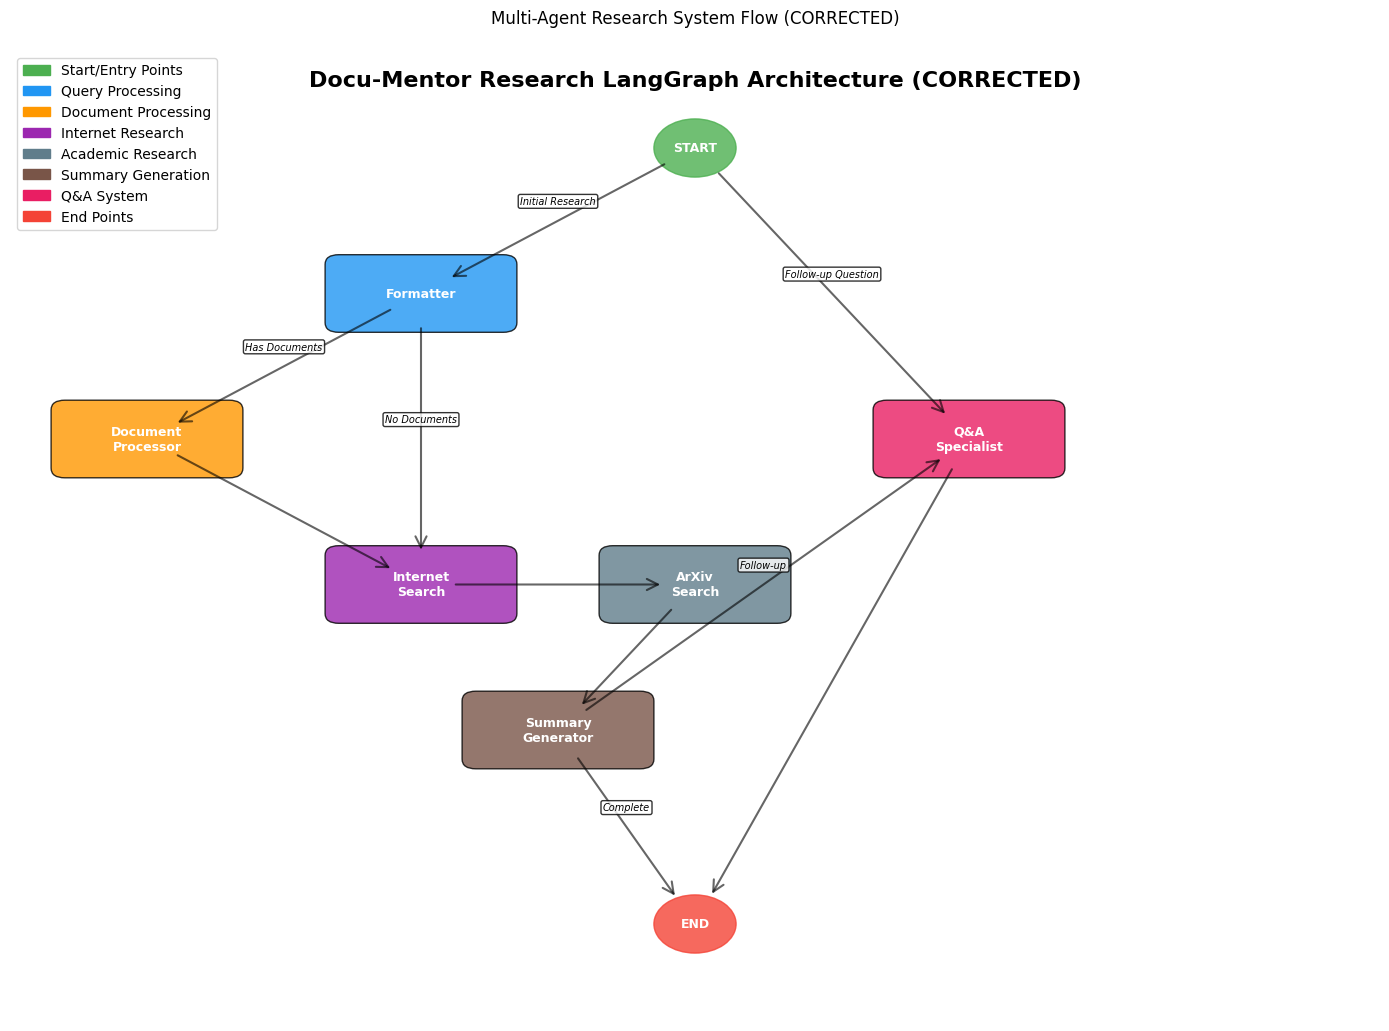

📊 Graph visualization displayed!


In [38]:
# === Graph Visualization - CORRECTED ===
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, ConnectionPatch
import numpy as np

def visualize_research_graph():
    """Create a visual representation of the research graph"""
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')
    
    # Define node positions and properties (UPDATED NAMES)
    nodes = {
        'START': {'pos': (5, 9), 'color': '#4CAF50', 'shape': 'circle'},
        'Formatter': {'pos': (3, 7.5), 'color': '#2196F3', 'shape': 'rect'},
        'Document\nProcessor': {'pos': (1, 6), 'color': '#FF9800', 'shape': 'rect'},
        'Internet\nSearch': {'pos': (3, 4.5), 'color': '#9C27B0', 'shape': 'rect'},
        'ArXiv\nSearch': {'pos': (5, 4.5), 'color': '#607D8B', 'shape': 'rect'},
        'Summary\nGenerator': {'pos': (4, 3), 'color': '#795548', 'shape': 'rect'},  # CHANGED NAME
        'Q&A\nSpecialist': {'pos': (7, 6), 'color': '#E91E63', 'shape': 'rect'},
        'END': {'pos': (5, 1), 'color': '#F44336', 'shape': 'circle'}
    }
    
    # Draw nodes
    for name, props in nodes.items():
        x, y = props['pos']
        color = props['color']
        
        if props['shape'] == 'circle':
            circle = plt.Circle((x, y), 0.3, color=color, alpha=0.8)
            ax.add_patch(circle)
        else:
            rect = FancyBboxPatch(
                (x-0.6, y-0.3), 1.2, 0.6,
                boxstyle="round,pad=0.1",
                facecolor=color,
                alpha=0.8,
                edgecolor='black',
                linewidth=1
            )
            ax.add_patch(rect)
        
        # Add text
        ax.text(x, y, name, ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    
    # Define connections (UPDATED)
    connections = [
        ('START', 'Formatter', 'Initial Research'),
        ('START', 'Q&A\nSpecialist', 'Follow-up Question'),
        ('Formatter', 'Document\nProcessor', 'Has Documents'),
        ('Formatter', 'Internet\nSearch', 'No Documents'),
        ('Document\nProcessor', 'Internet\nSearch', ''),
        ('Internet\nSearch', 'ArXiv\nSearch', ''),
        ('ArXiv\nSearch', 'Summary\nGenerator', ''),  # UPDATED
        ('Summary\nGenerator', 'Q&A\nSpecialist', 'Follow-up'),  # UPDATED
        ('Summary\nGenerator', 'END', 'Complete'),  # UPDATED
        ('Q&A\nSpecialist', 'END', '')
    ]
    
    # Draw connections
    for start, end, label in connections:
        start_pos = nodes[start]['pos']
        end_pos = nodes[end]['pos']
        
        # Create arrow
        arrow = ConnectionPatch(
            start_pos, end_pos,
            "data", "data",
            arrowstyle="->",
            shrinkA=25, shrinkB=25,
            mutation_scale=20,
            fc="black",
            alpha=0.6,
            linewidth=1.5
        )
        ax.add_patch(arrow)
        
        # Add label if exists
        if label:
            mid_x = (start_pos[0] + end_pos[0]) / 2
            mid_y = (start_pos[1] + end_pos[1]) / 2
            ax.text(mid_x, mid_y + 0.2, label, ha='center', va='center', 
                   fontsize=7, style='italic', 
                   bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))
    
    # Add title and legend
    ax.text(5, 9.7, 'Docu-Mentor Research LangGraph Architecture (CORRECTED)', 
           ha='center', va='center', fontsize=16, fontweight='bold')
    
    # Create legend
    legend_elements = [
        mpatches.Patch(color='#4CAF50', label='Start/Entry Points'),
        mpatches.Patch(color='#2196F3', label='Query Processing'),
        mpatches.Patch(color='#FF9800', label='Document Processing'),
        mpatches.Patch(color='#9C27B0', label='Internet Research'),
        mpatches.Patch(color='#607D8B', label='Academic Research'),
        mpatches.Patch(color='#795548', label='Summary Generation'),
        mpatches.Patch(color='#E91E63', label='Q&A System'),
        mpatches.Patch(color='#F44336', label='End Points')
    ]
    
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1))
    
    plt.tight_layout()
    plt.title('Multi-Agent Research System Flow (CORRECTED)', pad=20)
    plt.show()
    
    print("📊 Graph visualization displayed!")

# Display the corrected graph
visualize_research_graph()


In [40]:
# === FastAPI Application Setup - INTEGRATED WITH STATIC FILES ===
from fastapi import FastAPI, UploadFile, File, Form, HTTPException, Request
from fastapi.middleware.cors import CORSMiddleware
from fastapi.responses import JSONResponse, FileResponse
from fastapi.staticfiles import StaticFiles
from pydantic import BaseModel
from typing import List
import shutil
import uuid
import os

# Initialize FastAPI app
app = FastAPI(
    title="Docu-Mentor Research API",
    description="AI-powered research assistant with document processing and Q&A capabilities",
    version="1.0.0"
)

# Add CORS middleware
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # Configure appropriately for production
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

# Mount static files directory - SERVES CSS, JS, and other static assets
app.mount("/static", StaticFiles(directory="static"), name="static")

# Request/Response models
class ResearchRequest(BaseModel):
    question: str
    session_id: str = "default"
    is_followup: bool = False

class ResearchResponse(BaseModel):
    session_id: str
    formatted_question: str
    research_summary: str
    specialist_response: str = ""
    processing_stage: str
    sources_used: List[str]
    errors: List[str] = []

class QueryRequest(BaseModel):
    question: str
    documents: List[str] = []
    session_id: str
    new_session_id: str = "new"

class FollowupRequest(BaseModel):
    question: str
    session_id: str

# Global storage for uploaded files
UPLOAD_DIR = "uploads"
os.makedirs(UPLOAD_DIR, exist_ok=True)

# ============================================
# HTML PAGES - Serve the frontend files
# ============================================

@app.get("/", include_in_schema=False)
async def serve_index():
    """Serve the main index.html page"""
    return FileResponse("static/index.html")

@app.get("/summary", include_in_schema=False)
async def serve_summary():
    """Serve summary page (if you create one later)"""
    return FileResponse("static/index.html")  # Redirect to main page for now

@app.get("/mocktest", include_in_schema=False)
async def serve_mocktest():
    """Serve mock test page (placeholder)"""
    return FileResponse("static/index.html")  # Redirect to main page for now

# ============================================
# API ENDPOINTS - Match your frontend expectations
# ============================================

@app.post("/query")
async def query_endpoint(request: QueryRequest):
    """
    Main endpoint that matches your frontend JavaScript expectations
    """
    try:
        print(f"🔬 Processing query: {request.question[:50]}...")
        
        # Create initial state for your research system
        state = create_initial_state(
            original_question=request.question,
            session_id=request.session_id,
            uploaded_docs=request.documents
        )
        
        # Run the research pipeline using your LangGraph system
        result = await research_app.ainvoke(state)
        
        # Format response to match frontend expectations
        response = {
            "Reformulated Input": result.get("formatted_question", request.question),
            "Response": result.get("research_summary", "No summary generated"),
            "session_id": result.get("session_id", request.session_id),
            "processing_stage": result.get("processing_stage", "completed"),
            "errors": result.get("errors", [])
        }
        
        return response
        
    except Exception as e:
        print(f"❌ Query processing failed: {e}")
        return {
            "Reformulated Input": request.question,
            "Response": f"<p>I apologize, but I encountered an issue processing your request: {str(e)}</p><p>Please try again or contact support if the issue persists.</p>",
            "session_id": request.session_id,
            "processing_stage": "failed",
            "errors": [str(e)]
        }

@app.post("/upload-documents")
async def upload_documents(
    files: List[UploadFile] = File(...),
    session_id: str = Form(...)
):
    """
    Handle file uploads from the frontend
    """
    try:
        uploaded_paths = []
        
        for file in files:
            # Validate file size (50MB limit as specified in frontend)
            if file.size and file.size > 50 * 1024 * 1024:
                raise HTTPException(status_code=413, detail=f"File {file.filename} exceeds 50MB limit")
            
            # Generate unique filename
            file_id = str(uuid.uuid4())
            file_extension = os.path.splitext(file.filename)[1] if file.filename else ""
            unique_filename = f"{file_id}{file_extension}"
            file_path = os.path.join(UPLOAD_DIR, unique_filename)
            
            # Save file
            with open(file_path, "wb") as buffer:
                content = await file.read()
                buffer.write(content)
            
            uploaded_paths.append(file_path)
            print(f"📁 Uploaded: {file.filename} → {unique_filename}")
        
        return {
            "message": f"Successfully uploaded {len(uploaded_paths)} files",
            "file_paths": uploaded_paths,  # Match frontend expectation
            "filePaths": uploaded_paths,   # Alternative key for compatibility
            "session_id": session_id
        }
        
    except Exception as e:
        print(f"❌ File upload failed: {e}")
        raise HTTPException(status_code=500, detail=f"File upload failed: {str(e)}")

# ============================================
# FIXED FOLLOWUP ENDPOINT - HANDLES BOTH JSON AND FORM DATA
# ============================================

@app.post("/followup")
async def followup_question(
    request: Request,
    # For JSON requests
    json_data: FollowupRequest = None,
    # For form data requests
    question: str = Form(None),
    session_id: str = Form(None)
):
    """
    Handle follow-up questions from the frontend - UNIVERSAL VERSION
    Accepts both JSON payload and form data
    """
    try:
        # Determine the source of data (JSON vs Form)
        content_type = request.headers.get('content-type', '').lower()
        
        if 'application/json' in content_type and json_data:
            # JSON request
            final_question = json_data.question
            final_session_id = json_data.session_id
            print(f"💬 Follow-up question (JSON): {final_question[:50]}...")
        elif question and session_id:
            # Form data request
            final_question = question
            final_session_id = session_id
            print(f"💬 Follow-up question (Form): {final_question[:50]}...")
        else:
            # Try to parse JSON manually if needed
            try:
                body = await request.body()
                if body:
                    import json as json_lib
                    json_payload = json_lib.loads(body.decode())
                    final_question = json_payload.get('question')
                    final_session_id = json_payload.get('session_id')
                    print(f"💬 Follow-up question (Manual JSON): {final_question[:50] if final_question else 'None'}...")
                else:
                    raise ValueError("No data received")
            except Exception as parse_error:
                print(f"❌ Could not parse request data: {parse_error}")
                return JSONResponse(
                    status_code=400,
                    content={
                        "error": "Invalid request format. Please send either JSON with {question, session_id} or form data.",
                        "content_type": content_type,
                        "received_json": json_data is not None,
                        "received_form": question is not None and session_id is not None
                    }
                )
        
        if not final_question or not final_session_id:
            return JSONResponse(
                status_code=400,
                content={
                    "error": "Missing required fields: question and session_id",
                    "received_question": final_question is not None,
                    "received_session_id": final_session_id is not None
                }
            )
        
        # Get existing research context from your session system
        try:
            chat_hist = get_chat_history(final_session_id)
        except Exception as e:
            print(f"⚠️ Could not get chat history: {e}")
            # Provide a general response if no history exists
            return {
                "session_id": final_session_id,
                "question": final_question,
                "specialist_response": f"I understand you're asking about: {final_question}. However, I don't have the context from a previous research session. Please conduct a research query first, then I can provide more specific follow-up answers.",
                "processing_stage": "no_context",
                "response_type": "general"
            }
        
        # Find existing research summary
        existing_summary = ""
        if hasattr(chat_hist, 'messages') and chat_hist.messages:
            for message in reversed(chat_hist.messages):
                if hasattr(message, 'content') and len(str(message.content)) > 50:
                    # Look for research summary content
                    content_str = str(message.content)
                    if any(keyword in content_str.lower() for keyword in ["research", "summary", "analysis", "findings"]):
                        existing_summary = content_str
                        break
        
        if not existing_summary:
            # Provide general explanation instead of erroring
            return {
                "session_id": final_session_id,
                "question": final_question,
                "specialist_response": f"Great question about {final_question}! To provide the most accurate and contextual answer, I'd recommend conducting a research query first. This will give me the necessary background to provide detailed, well-sourced responses to your follow-up questions.",
                "processing_stage": "general_response",
                "response_type": "general"
            }
        
        # Create state for Q&A specialist with enhanced prompting
        try:
            state = create_initial_state(
                original_question="",
                session_id=final_session_id
            )
            
            state = update_research_state(
                state,
                user_question=final_question,
                current_context=existing_summary,
                research_summary=existing_summary
            )
            
            # Run Q&A specialist with chat-optimized prompting
            result = await qa_specialist_node(state)
            
            specialist_response = result.get("specialist_response", "I couldn't generate a response. Please try rephrasing your question.")
            
            # Add to chat history
            if hasattr(chat_hist, 'add_user_message'):
                chat_hist.add_user_message(f"Follow-up: {final_question}")
                chat_hist.add_ai_message(f"Assistant: {specialist_response}")
            
            return {
                "session_id": final_session_id,
                "question": final_question,
                "specialist_response": specialist_response,
                "processing_stage": result.get("processing_stage", "completed"),
                "response_type": "contextualized"
            }
            
        except Exception as e:
            print(f"❌ Q&A specialist processing failed: {e}")
            # Fallback response
            return {
                "session_id": final_session_id,
                "question": final_question,
                "specialist_response": f"I understand you're asking about {final_question}. While I encountered a technical issue accessing the research context, I can tell you that this is an interesting topic that would benefit from a dedicated research session.",
                "processing_stage": "fallback",
                "response_type": "fallback"
            }
        
    except Exception as e:
        print(f"❌ Follow-up question failed: {e}")
        return JSONResponse(
            status_code=500,
            content={
                "error": f"I encountered an error: {str(e)}",
                "suggestion": "Please try again or start a new research session.",
                "session_id": final_session_id if 'final_session_id' in locals() else "unknown"
            }
        )

# Alternative endpoint for form-based followup (if your frontend sends form data)
@app.post("/followup-form")
async def followup_question_form(
    question: str = Form(...),
    session_id: str = Form(...)
):
    """
    Handle follow-up questions sent as form data
    """
    # Convert to Pydantic model and use the main followup function
    request = FollowupRequest(question=question, session_id=session_id)
    return await followup_question(request)

@app.post("/research", response_model=ResearchResponse)
async def conduct_research(request: ResearchRequest):
    """
    Alternative research endpoint for direct API usage
    """
    try:
        print(f"🔬 Research request: {request.question[:50]}...")
        
        # Create initial state
        state = create_initial_state(
            original_question=request.question,
            session_id=request.session_id
        )
        
        # Run the research pipeline
        result = await research_app.ainvoke(state)
        
        # Determine sources used
        sources_used = []
        if result.get("uploaded_documents"):
            sources_used.append("Uploaded Documents")
        if result.get("internet_results"):
            sources_used.append("Internet Search")
        if result.get("arxiv_results"):
            sources_used.append("Academic Papers (ArXiv)")
        
        return ResearchResponse(
            session_id=result["session_id"],
            formatted_question=result.get("formatted_question", request.question),
            research_summary=result.get("research_summary", ""),
            processing_stage=result.get("processing_stage", "unknown"),
            sources_used=sources_used,
            errors=result.get("errors", [])
        )
        
    except Exception as e:
        print(f"❌ Research request failed: {e}")
        raise HTTPException(status_code=500, detail=f"Research processing failed: {str(e)}")

@app.post("/research-with-documents")
async def research_with_documents(
    question: str = Form(...),
    session_id: str = Form(...),
    files: List[UploadFile] = File(None)
):
    """
    Combined endpoint for research with document uploads
    """
    try:
        uploaded_paths = []
        
        # Process uploaded files if any
        if files:
            for file in files:
                if file.filename:  # Check if file was actually uploaded
                    # Validate file size
                    if file.size and file.size > 50 * 1024 * 1024:
                        raise HTTPException(status_code=413, detail=f"File {file.filename} exceeds 50MB limit")
                    
                    file_id = str(uuid.uuid4())
                    file_extension = os.path.splitext(file.filename)[1]
                    unique_filename = f"{file_id}{file_extension}"
                    file_path = os.path.join(UPLOAD_DIR, unique_filename)
                    
                    content = await file.read()
                    with open(file_path, "wb") as buffer:
                        buffer.write(content)
                    
                    uploaded_paths.append(file_path)
        
        # Create state with documents
        state = create_initial_state(
            original_question=question,
            session_id=session_id,
            uploaded_docs=uploaded_paths
        )
        
        # Run research pipeline
        result = await research_app.ainvoke(state)
        
        # Determine sources used
        sources_used = []
        if uploaded_paths:
            sources_used.append("Uploaded Documents")
        if result.get("internet_results"):
            sources_used.append("Internet Search")
        if result.get("arxiv_results"):
            sources_used.append("Academic Papers")
        
        return ResearchResponse(
            session_id=result["session_id"],
            formatted_question=result.get("formatted_question", question),
            research_summary=result.get("research_summary", ""),
            processing_stage=result.get("processing_stage", "unknown"),
            sources_used=sources_used,
            errors=result.get("errors", [])
        )
        
    except Exception as e:
        print(f"❌ Research with documents failed: {e}")
        raise HTTPException(status_code=500, detail=str(e))

# ============================================
# UTILITY ENDPOINTS
# ============================================

@app.get("/health")
async def health_check():
    """Health check endpoint"""
    return {
        "status": "healthy", 
        "service": "Docu-Mentor Research API",
        "static_files": "integrated",
        "upload_directory": UPLOAD_DIR
    }

@app.get("/api/info")
async def api_info():
    """API information endpoint"""
    return {
        "message": "Docu-Mentor Research API",
        "version": "1.0.0",
        "frontend": "integrated",
        "endpoints": {
            "main_page": "/",
            "query": "/query",
            "upload": "/upload-documents", 
            "research_with_docs": "/research-with-documents",
            "followup": "/followup",
            "followup_form": "/followup-form",
            "health": "/health"
        },
        "static_files": {
            "css": "/static/styles.css",
            "js": "/static/script.js",
            "assets": "/static/*"
        }
    }

# ============================================
# ERROR HANDLERS
# ============================================

@app.exception_handler(404)
async def custom_404_handler(request: Request, exc: HTTPException):
    """Custom 404 handler - redirect to main page"""
    return FileResponse("static/index.html")

@app.exception_handler(413)
async def file_too_large_handler(request: Request, exc: HTTPException):
    """Handle file size too large errors"""
    return JSONResponse(
        status_code=413,
        content={"error": "File size exceeds 50MB limit", "detail": str(exc.detail)}
    )

from fastapi.exceptions import RequestValidationError
from fastapi import Request, status
from fastapi.responses import JSONResponse

@app.exception_handler(RequestValidationError)
async def validation_exception_handler(request: Request, exc: RequestValidationError):
    """Catch and log validation errors for debugging"""
    print(f"❌ Validation Error on {request.url}")
    print(f"Request method: {request.method}")
    print(f"Content-Type: {request.headers.get('content-type', 'Not set')}")
    print(f"Error details: {exc.errors()}")
    
    # Don't try to serialize the raw body in JSON response
    error_details = []
    for error in exc.errors():
        clean_error = {
            'type': error.get('type'),
            'location': error.get('loc'),
            'message': error.get('msg'),
            'input_type': str(type(error.get('input'))) if error.get('input') is not None else 'None'
        }
        error_details.append(clean_error)
    
    # Return detailed error info for debugging
    return JSONResponse(
        status_code=status.HTTP_422_UNPROCESSABLE_ENTITY,
        content={
            "error": "Validation failed",
            "details": error_details,
            "message": "Check server logs for details",
            "endpoint": str(request.url),
            "method": request.method,
            "content_type": request.headers.get('content-type', 'Not set')
        }
    )

print("✅ FastAPI application configured and integrated with static files")
print("📁 Static files served from /static/")
print("🏠 Main page served at /")
print("🔗 API endpoints ready for frontend integration")
print("🔧 Fixed followup endpoint - accepts JSON payload")

# ============================================
# DEVELOPMENT SERVER
# ============================================

if __name__ == "__main__":
    import nest_asyncio
    import uvicorn

    # Enable nested event loops (required for running uvicorn in Jupyter)
    nest_asyncio.apply()

    # Run the FastAPI server
    uvicorn.run(app, host="127.0.0.1", port=8000)

✅ FastAPI application configured and integrated with static files
📁 Static files served from /static/
🏠 Main page served at /
🔗 API endpoints ready for frontend integration
🔧 Fixed followup endpoint - accepts JSON payload


INFO:     Started server process [16588]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


📁 Uploaded: lyu_paper_reference 10.pdf → 81733601-2350-4c2b-8195-91efe202e9c1.pdf
INFO:     127.0.0.1:49316 - "POST /upload-documents HTTP/1.1" 200 OK
🔬 Processing query: explain this paper...
🔀 Routing: Has context: False, User question: False
→ Routing to formatter for new research
🔧 Starting query formatting...
✅ Query formatted: explain this paper... → Summarize the key findings and arguments presented...
→ Has documents, routing to document processing
📁 Starting document processing...
⚠️ Tesseract OCR not available
📄 Processing PDF: uploads/81733601-2350-4c2b-8195-91efe202e9c1.pdf
✅ Document processing completed: 1 documents processed
🌐 Starting internet search...
🔍 Using Brave Search API...
✅ Brave Search: Found 10 results
📚 Starting ArXiv search...
🔍 Searching ArXiv for: Summarize the key findings and arguments presented in [insert paper title and authors].


/var/folders/2n/23l2n0fs16g6_dgvpwr6lmp40000gn/T/ipykernel_16588/2808686964.py:23: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for paper in search.results():


⚠️ No ArXiv papers found
📝 Generating comprehensive research summary...
❌ Research summary generation failed: Error code: 413 - {'error': {'message': 'Request too large for model `gemma2-9b-it` in organization `org_01jkzgq2qwezn839sk241mda78` service tier `on_demand` on tokens per minute (TPM): Limit 15000, Requested 18413, please reduce your message size and try again. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}
→ Research complete, ending
INFO:     127.0.0.1:49316 - "POST /query HTTP/1.1" 200 OK
🔬 Processing query: explain this paperattention is all you need...
🔀 Routing: Has context: False, User question: False
→ Routing to formatter for new research
🔧 Starting query formatting...
✅ Query formatted: explain this paperattention is all you need... → Explain the Transformer model architecture and its...
→ No documents, routing to internet search
🌐 Starting internet search...
🔍 Using Brave S

/var/folders/2n/23l2n0fs16g6_dgvpwr6lmp40000gn/T/ipykernel_16588/2808686964.py:23: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for paper in search.results():


✅ ArXiv search completed: 8 papers found
📝 Generating comprehensive research summary...
✅ Research summary generated successfully
→ Research complete, ending
INFO:     127.0.0.1:49340 - "POST /query HTTP/1.1" 200 OK
🔬 Processing query: explain this paperattention is all you need...
🔀 Routing: Has context: False, User question: False
→ Routing to formatter for new research
🔧 Starting query formatting...
✅ Query formatted: explain this paperattention is all you need... → Explain the Transformer model architecture and its...
→ No documents, routing to internet search
🌐 Starting internet search...
🔍 Using Brave Search API...
✅ Brave Search: Found 10 results
📚 Starting ArXiv search...
🔍 Searching ArXiv for: Explain the Transformer model architecture and its impact on natural language processing, specifically focusing on the "Attention is All You Need" paper.
✅ ArXiv search completed: 8 papers found
📝 Generating comprehensive research summary...


/var/folders/2n/23l2n0fs16g6_dgvpwr6lmp40000gn/T/ipykernel_16588/2808686964.py:23: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for paper in search.results():


✅ Research summary generated successfully
→ Research complete, ending
INFO:     127.0.0.1:49351 - "POST /query HTTP/1.1" 200 OK
💬 Follow-up question (Manual JSON): what is a tranformer here explain...
INFO:     127.0.0.1:49359 - "POST /followup HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [16588]
